Lesson: M931LT1 Artificial Intelligence II

Fall Semester 2021

Student's name: Christina Christodoulou

I.D Number: LT1200027

Field of Studies: Language Technology

Homework 1

In [1]:
# Import necessary libraries
import re 
import matplotlib.pyplot as plt 
import pandas as pd  
import pickle
import nltk
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
# Download necessary packages
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
stop_words_set = set(stopwords.words("english"))

In [4]:
# A function that opens, reads a file in csv with utf-8 encoding, gets the values, checks and fills empty values and checks for duplicates
def read_explore_dataframe(csv_file):
  
  # Open and read the csv file with utf-8 encoding
  dataframe = pd.read_csv(csv_file,encoding='utf-8')
  
  # Get the keys and their corresponding number of values
  keys = dataframe.keys() 
  for key in keys:
    df_len = len(dataframe[key].unique()) # the length of the unique values of each column
    print('{0:25}{1:10}'.format(key,df_len))

  dataframe.dropna(inplace=True) # remove missing values and keep the dataFrame with valid entries in the same variable
  dataframe.reset_index(inplace=True,drop=True)

  dataframe.duplicated() # check for duplicates
  #print('Number of duplicates in the dataframe:', dataframe.duplicated().sum())
  print('Dataframe checked for NaN values and duplicates!')
  
  return dataframe 

In [5]:
# A function that takes as parameter a text and applies pre-processing steps to clean it
def text_preprocessing(text):
  
  # Remove tags
  TAG_RE = re.compile(r'<[^>]+>')
  no_tags = TAG_RE.sub('',text)  
                
  # Remove unusual characters
  text = re.sub('<[^>]*>', '', no_tags)

  # Remove urls
  text = re.sub(r'http\S+','', text)
    
  # Remove emoticons
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

  # Remove punctuation
  no_punct = [word for word in emoticons if word.isalpha()]
                
  # Convert all words to lowercase
  text = re.sub('[\W]+', ' ', text.lower()) + " ".join(no_punct).replace('-', '')
    
  # Remove numbers
  no_numbers_txt = re.sub(r'\d+', '', text)

  return no_numbers_txt

In [6]:
def get_columns_vectorize_split(dataframe, feature, label,test_size):
  
  # Get only the columns we are interested in
  dataset = dataframe[[feature,label]]
  
  # Check the distribution of classes
  distribution = dataset[label].value_counts()/dataset.shape[0]
  print('Distribution of data in classes:')
  print(distribution)

  # Separate the different labels and create a combined dataset
  neutral = dataset[dataset[label] == 0]
  antivax = dataset[dataset[label] == 1]
  provax = dataset[dataset[label] == 2]

  # Combine the classes with the greater number of values
  class_majorities = pd.concat([neutral,provax])
  classes = pd.concat([neutral,antivax,provax])

  # Upsampling: take samples with replacement from the minority class until the class is almost the same size as the majorities
  train_minority_upsampled = resample(antivax, replace=True, n_samples=len(classes),random_state=123)
  train_minority_upsampled2 = resample(neutral, replace=True, n_samples=len(classes),random_state=123)
  train_minority_upsampled3 = resample(provax, replace=True, n_samples=len(classes),random_state=123)
  
  # Combine in a new dataframe the new resampled classes 
  dataset = pd.concat([train_minority_upsampled,train_minority_upsampled2,train_minority_upsampled3]) 
  print('Distribution of data in classes after resampling:')
  print(dataset[label].value_counts())
  
  # Apply the pre-processing function to the dataframe containing the text (feature column)
  dataset[feature] = dataset[feature].apply(text_preprocessing)
  print('\nText done pre-processing!')
  
  # Divide the X and y values
  X = dataset[feature]
  y = dataset[label]
  
  # Print to see the input variables
  print(X[:3])

  # Split the dataset according to the chosen test size as parameter
  X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = test_size, random_state=42)
  print('The dataset is split and ready for training!')

  print('X_train shape:',X_train.shape)
  print('Y_train shape:',Y_train.shape)
  print('X_test shape:',X_test.shape)
  print('Y_test shape:',Y_test.shape)
  
  # Instantiate a TF-IDF Vectorizer
  #tfidf = TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1, 1), tokenizer = nltk.word_tokenize)
  #X_train = tfidf.fit_transform(X_train)
  #X_test  = tfidf.transform(X_test)
  #print('Number of features:',len(tfidf.vocabulary_))

  # Instantiate a CountVectorizer
  vectorizer = CountVectorizer(lowercase=True, stop_words="english", ngram_range=(1, 1), tokenizer = nltk.word_tokenize)
  X_train = vectorizer.fit_transform(X_train)
  X_test  = vectorizer.transform(X_test)
  print('Number of features:',len(vectorizer.vocabulary_))

  return X_train, X_test, Y_train, Y_test

In [7]:
# Draw the plot of the target variable - training set
def plot_target_values(csv_file,target_label):
  
  dataframe = pd.read_csv(csv_file,encoding='utf-8')
  sns.countplot(x=target_label, data=dataframe)

In [8]:
# A function that takes as parameters the split X_train and Y_train values
# It creates a logistic regression model and uses the GridSearch to search for the best C parameter and compute accuracy of model
# The best C parameter will be used to the vaccine sentiment classifier
def search_best_parameters(X_train,Y_train):
  
  # Create a logistic regression model       
  logreg = LogisticRegression(class_weight='balanced',max_iter = 1000)
  # Initiate C parameters
  grid={'C':[0.001, 0.01, 0.1, 1, 10, 100,1000]}
  logreg_cv=GridSearchCV(logreg,grid,n_jobs=-1)
  logreg_cv.fit(X_train,Y_train)

  print('Best parameters:',logreg_cv.best_params_)
  print('Accuracy:',logreg_cv.best_score_)

  return logreg

In [23]:
# A function that takes as parameters the split X_train and Y_train values, uses the best C parameter from the previous function to train a softmax regression classifier
# It also plots learning curves to check overfitting or underfitting issues and saves the model in pickle
def train(X_train,Y_train):
  
  print('\n------ TRAINING... ------')
   
  # Create a logistic regression model (LR)       
  LR = LogisticRegression(C = 0.1, class_weight ='balanced', max_iter = 1000)

  # Train the model using train set
  LR.fit(X_train, Y_train)

  print('Number of iterations: {}'.format(LR.n_iter_))
  
  # Use the learning curve to get training and test scores along with train sizes
  train_sizes, train_scores, test_scores = learning_curve(LR, X_train, Y_train, cv=10, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5))

  # Calculate the mean and the standard deviation of the train and test scores 
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
    
  plt.figure()
  plt.title('Logistic Regression Model')
  plt.xlabel('Training examples')
  plt.ylabel('Score')
  plt.gca().invert_yaxis()
  plt.grid()
    
  # Plot the std deviation as a transparent range at each training set size
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
  # Plot the average training and test score lines at each training set size
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
  # It sizes the window for readability and displays the plot and shows error from 0 to 1.1
  plt.ylim(-.1,1.1)
  plt.show()
  
  # Save the model to a disk
  #filename = '/content/Logistic_regression_model_20_tfidf.sav'
  filename = '/content/Logistic_regression_model_20_countvectorizer.sav'
  pickle.dump(LR, open(filename, 'wb'))
  print('The model saved is saved in pickle form!\n')
  
  return train_scores_mean,train_scores_std,test_scores_mean,test_scores_std

In [10]:
# A function that takes as parameters the split X and Y values as well as the trained model in pickle
# It makes predictions and calculates accuracy, precision, recall and f-measure
# It plots learning curves to check overfitting or underfitting issues and plots the confusion matrix
def predict_evaluate_classifier(X_train, X_test, Y_train, Y_test,saved_model):

  print('\n------ PREDICTING AND EVALUATING... ------')
  # Load the model    
  loaded_model = pickle.load(open(saved_model, 'rb'))
       
  # Train the model using train set
  loaded_model.fit(X_train,Y_train)
  print('\nFitting data to the loaded logistic regression model...')
                
  # Make model predictions
  y_test_predict = loaded_model.predict(X_test)

  print('\nThe Beta parameters:', loaded_model.coef_)
  print('\nThe Intercept (bias):', loaded_model.intercept_)        
  
  # Calculate accuracy of Logistic regression model 
  LR_accuracy = metrics.accuracy_score(Y_test,y_test_predict)*100

  # Precision score
  precision = metrics.precision_score(Y_test,y_test_predict,average='micro')*100
  
  # Recall Score
  recall = metrics.recall_score(Y_test,y_test_predict,average='micro')*100
   
  # F measure score
  f_measure = metrics.f1_score(Y_test,y_test_predict,average='micro')*100
  
  print('\nMetrics:')
  print('Accuracy: {} %'.format(LR_accuracy))
  
  precision, recall, fscore, support = score(Y_test,y_test_predict)

  print('precision: {}'.format(precision))
  print('recall: {}'.format(recall))
  print('fscore: {}'.format(fscore))
  print('support: {}'.format(support))
  
  # Get the classificatin report from the confusion matrix
  print('\nClassification report:\n',classification_report(Y_test,y_test_predict,labels = np.unique(y_test_predict)))

  # Use the learning curve to get training and test scores along with train sizes
  train_sizes, train_scores, test_scores = learning_curve(loaded_model, X_train, Y_train, cv=10, n_jobs=1, train_sizes=np.linspace(0.01, 1.0, 5))

  # Calculate the mean and the standard deviation of the train and test scores 
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
    
  plt.figure()
  plt.title('Logistic Regression Model')
  plt.xlabel('Training examples')
  plt.ylabel('Score')
  plt.gca().invert_yaxis()
  plt.grid()
    
  # Plot the std deviation as a transparent range at each training set size
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
  # Plot the average training and test score lines at each training set size
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
  # It sizes the window for readability and displays the plot and shows error from 0 to 1.1
  plt.ylim(-.1,1.1)
  plt.show()
   
  cm = confusion_matrix(Y_test,y_test_predict)
  # Visualize the confusion matrix
  conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0', 'Predicted:1','Predicted:2'], index =['True:0', 'True:1','True:2'])
  plt.figure(figsize = (8, 5))
  sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Spectral")
  
  return plt.show()

In [11]:
# THIS IS USED FOR THE TRAINING SET
# A function that includes 3 functions
# The first function reads the dataframe, checks for NaN values and for duplicates
# The second function gets the data from the specified columns, pre-processes text, creates arrays, vectorizes and splits into training and test sets according to a given ratio 
# The third function uses the SearchGrid to search for the best C logistic regression parameter
# It was run first and the best C parameter was used as input in the function 'train(X_train,Y_train)'
def find_best_parameters_model(csv_file,feature,label):
  
  df = read_explore_dataframe(csv_file)
  X_train, X_test, Y_train, Y_test = get_columns_vectorize_split(df,feature,label,0.2)  
  model = search_best_parameters(X_train,Y_train)

  return model

In [12]:
# THIS IS USED FOR THE TRAINING SET
# A function that includes 3 functions
# The first function reads the dataframe, checks for NaN values and for duplicates
# The second function gets the data from the specified columns, pre-processes text, creates arrays,vectorizes and splits into training and test sets according to a given ratio 
# The third function trains a logistic regression model and saves it to pickle form
def data_train_model(csv_file,feature,label):
  
  df = read_explore_dataframe(csv_file)
  X_train, X_test, Y_train, Y_test = get_columns_vectorize_split(df,feature,label,0.2)  
  train_scores_mean,train_scores_std,test_scores_mean,test_scores_std = train(X_train,Y_train)

  return train_scores_mean,train_scores_std,test_scores_mean,test_scores_std

In [13]:
# THIS IS USED FOR THE VALIDATION SET AND MEANT TO BE USED FOR THE TEST SET
# A function that includes 3 functions
# The first function reads the dataframe, checks for NaN values and for duplicates
# The second function gets the data from the specified columns, pre-processes text, creates arrays,vectorizes and splits into training and test sets according to a given ratio 
# The third function uses the saved model to predict and evaluates the classifier
def data_evaluate_model(csv_file,feature,label,saved_model):
  
  df_eval = read_explore_dataframe(csv_file)
  x_train, y_train, x_test, y_test = get_columns_vectorize_split(df_eval,feature,label,0.2)
  class_matrix = predict_evaluate_classifier(x_train, y_train, x_test, y_test,saved_model)

  return class_matrix 

**APPLICATION OF FUNCTIONS**

**TRAINING SET: FIND THE BEST PARAMETERS FOR THE LOGISTIC REGRESSION MODEL**

In [14]:
df_part_one = find_best_parameters_model('vaccine_train_set.csv','tweet','label')

Unnamed: 0                    15976
tweet                         15881
label                             3
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466825
2    0.403418
1    0.129757
Name: label, dtype: float64
Distribution of data in classes after resampling:
2    15976
1    15976
0    15976
Name: label, dtype: int64

Text done pre-processing!
10783    newborn seized from mom in pennsylvania hospit...
8997      cz_binance survival rate for covid is   accor...
13678    it takes ten years for a vaccine to develop th...
Name: tweet, dtype: object
The dataset is split and ready for training!
X_train shape: (38342,)
Y_train shape: (38342,)
X_test shape: (9586,)
Y_test shape: (9586,)
Number of features: 21400
Best parameters: {'C': 10}
Accuracy: 0.944290902006894


**TRAINING SET: TRAIN A LOGISTIC REGRESSION MODEL**

Unnamed: 0                    15976
tweet                         15881
label                             3
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466825
2    0.403418
1    0.129757
Name: label, dtype: float64
Distribution of data in classes after resampling:
2    15976
1    15976
0    15976
Name: label, dtype: int64

Text done pre-processing!
10783    newborn seized from mom in pennsylvania hospit...
8997      cz_binance survival rate for covid is   accor...
13678    it takes ten years for a vaccine to develop th...
Name: tweet, dtype: object
The dataset is split and ready for training!
X_train shape: (38342,)
Y_train shape: (38342,)
X_test shape: (9586,)
Y_test shape: (9586,)
Number of features: 21400

------ TRAINING... ------
Number of iterations: [111]


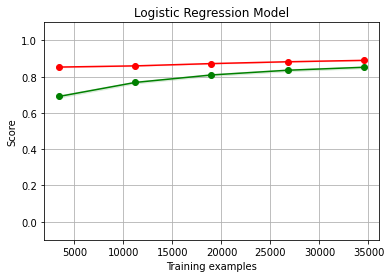

The model saved is saved in pickle form!



In [24]:
df = data_train_model('vaccine_train_set.csv','tweet','label')

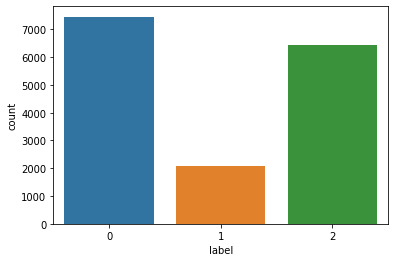

In [25]:
# Draw the plot of the target variable - training set
plot_target_values('vaccine_train_set.csv','label')  

**VALIDATION SET & TEST SET: MODEL EVALUATION**

NOTE: For the test set to run, just change the name of the source csv file and use the trained 'Logistic_regression_model.sav' that was included in the zip file. 

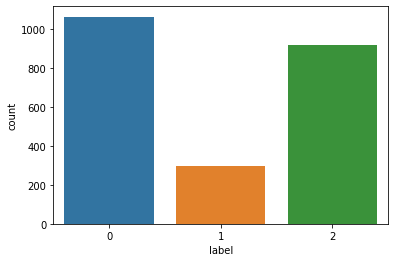

In [26]:
# Draw the plot of the target variable - validation and testing set
plot_target_values('vaccine_validation_set.csv','label')  

Unnamed: 0                     2282
tweet                          2276
label                             3
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466696
2    0.403593
1    0.129711
Name: label, dtype: float64
Distribution of data in classes after resampling:
2    2282
1    2282
0    2282
Name: label, dtype: int64

Text done pre-processing!
850      tennessee woman paralyzed after second pfizer...
1855    still not taking it vaccines take years of res...
132               great documentary on vaccines nova pbs 
Name: tweet, dtype: object
The dataset is split and ready for training!
X_train shape: (5476,)
Y_train shape: (5476,)
X_test shape: (1370,)
Y_test shape: (1370,)
Number of features: 6139

------ PREDICTING AND EVALUATING... ------

Fitting data to the loaded logistic regression model...

The Beta parameters: [[ 0.17284279 -0.04339197  0.0687994  ...  0.25551627 -0.04418221
   0.06729962]
 [-0.07536005 -0.03174656 -0.03777602 ... 

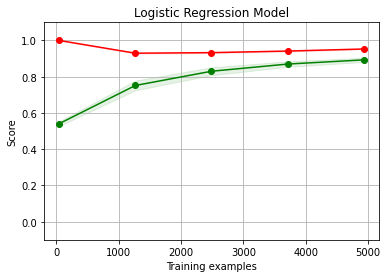

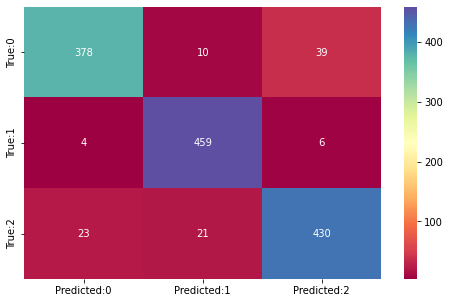

In [27]:
data_evaluate_model('vaccine_validation_set.csv','tweet','label','Logistic_regression_model_20_countvectorizer.sav')